In [2]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as io
import csv

from umap import UMAP
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding

In [3]:
#sparse.save_npz("brain_data_complete.npz", dat)
new_dat = sparse.load_npz("brain_data_complete.npz")

In [4]:
new_dat = sparse.coo_matrix(sparse.csr_matrix(new_dat) + sparse.csr_matrix(new_dat.T))

In [5]:
new_dat = new_dat.todense()

In [6]:
from sklearn.utils.graph_shortest_path import graph_shortest_path

In [100]:
from copy import copy
dat_inv = copy(new_dat)

In [101]:
dat_inv.data = 1 - dat_inv.data 

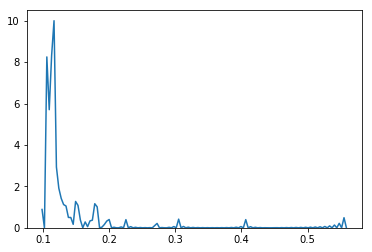

In [102]:
import seaborn as sns
sns.kdeplot(np.random.choice(dat.data, 1000))
plt.show()

In [12]:
from sklearn.manifold import SpectralEmbedding

spectral = SpectralEmbedding(n_components=3, affinity='precomputed', n_jobs=6)
coords = spectral.fit_transform(new_dat)

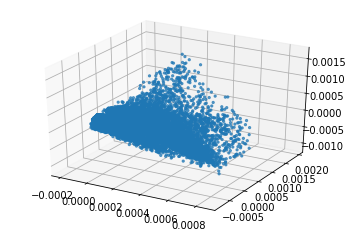

In [13]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(coords[:,0], coords[:,1], coords[:,2], s=5, alpha=0.7)
plt.show()

In [21]:
from sklearn.neighbors import kneighbors_graph
from copy import copy
neighbors_graph = kneighbors_graph(1-new_dat, n_neighbors=30, metric='precomputed', n_jobs=6)

In [54]:
nnz_ind = neighbors_graph.nonzero()
neighbors_distances = copy(neighbors_graph)

# have to recast matrix to the proper shape array
neighbors_distances.data = np.squeeze(np.array(new_dat[nnz_ind]))

In [55]:
geodesic_distances = graph_shortest_path(neighbors_distances, directed=False, method='D')

In [68]:
u_geo = UMAP(metric='precomputed', n_neighbors=10, min_dist=.4)
coords_geo = u_geo.fit_transform(geodesic_distances)

/anaconda3/lib/python3.6/site-packages/umap/umap_.py:1439: UserWarning: Using precomputed metric; transform will be unavailable for new data
  warn('Using precomputed metric; transform will be unavailable for new data')


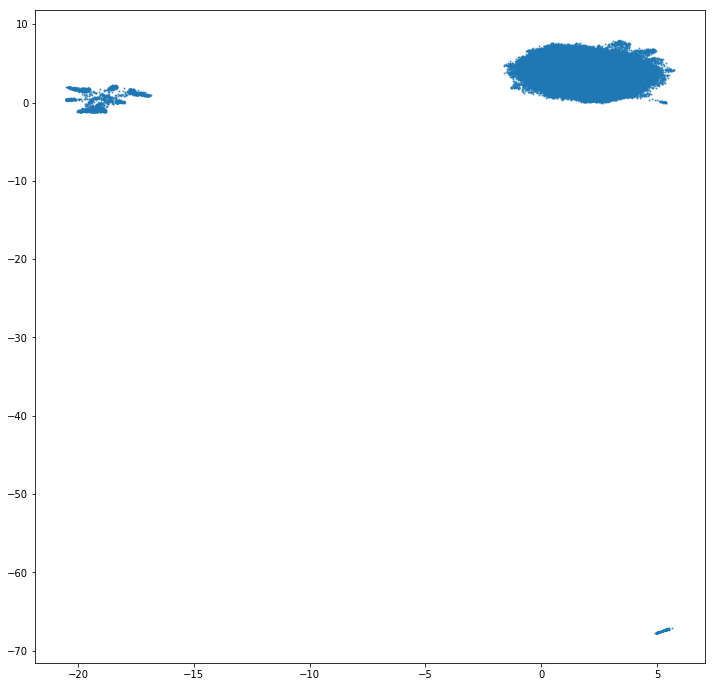

In [69]:
fig, ax = plt.subplots(figsize=(12,12))

plt.scatter(x=coords_geo[:,0], y=coords_geo[:,1], s=1, alpha=.7)
plt.show()

In [62]:
from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=10, n_jobs=6)
coords = iso.fit_transform(1-new_dat)

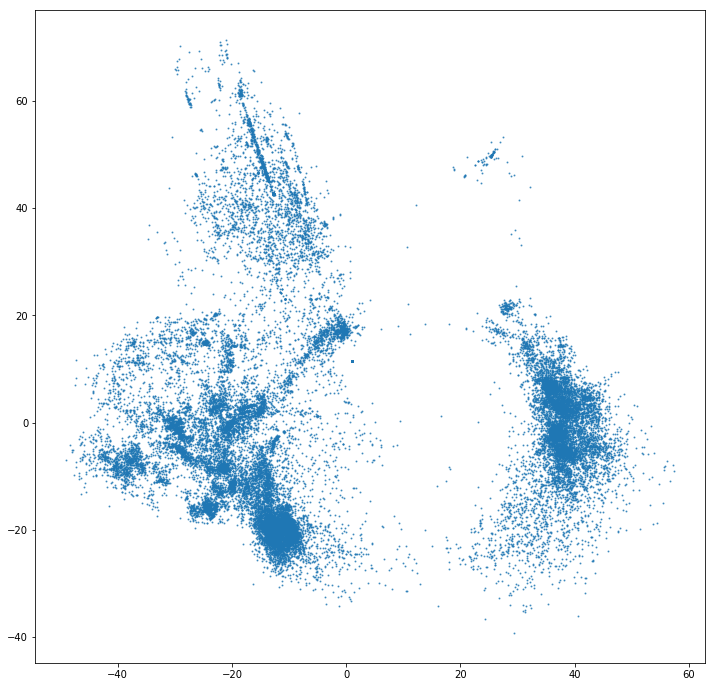

In [65]:
fig, ax = plt.subplots(figsize=(12,12))

plt.scatter(x=coords[:,0], y=coords[:,1], s=1, alpha=.7)
plt.show()

In [ ]:
u_geo = UMAP(metric='precomputed', n_neighbors=30)
coords_geo = u_geo.fit_transform(new_dat)
plt.scatter(x=coords_geo[:,0], y=coords_geo[:,1], s=5, alpha=.7)
plt.show()

/anaconda3/lib/python3.6/site-packages/umap/umap_.py:1439: UserWarning: Using precomputed metric; transform will be unavailable for new data
  warn('Using precomputed metric; transform will be unavailable for new data')


In [ ]:
fig, axes = plt.subplots(figsize=(16,30), nrows=5, ncols=3)
plt.tight_layout()

distances = [.01, .1, .5]

for i in range(5):
    for j in range(3):
        u_m = UMAP(metric='precomputed', n_neighbors=10+i*10, min_dist=distances[j])
        coords_m = u_m.fit_transform(geodesic_distances)
        
        axes[i][j].scatter(coords_m[:, 0], coords_m[:, 1], alpha = .4, s=1)
        axes[i][j].axis('off')
    
plt.savefig('umap_10_to_60_neighbors_001_01_05_distances.pdf')
plt.show()

/anaconda3/lib/python3.6/site-packages/umap/umap_.py:1439: UserWarning: Using precomputed metric; transform will be unavailable for new data
  warn('Using precomputed metric; transform will be unavailable for new data')
/anaconda3/lib/python3.6/site-packages/umap/umap_.py:1439: UserWarning: Using precomputed metric; transform will be unavailable for new data
  warn('Using precomputed metric; transform will be unavailable for new data')
/anaconda3/lib/python3.6/site-packages/umap/umap_.py:1439: UserWarning: Using precomputed metric; transform will be unavailable for new data
  warn('Using precomputed metric; transform will be unavailable for new data')
/anaconda3/lib/python3.6/site-packages/umap/umap_.py:1439: UserWarning: Using precomputed metric; transform will be unavailable for new data
  warn('Using precomputed metric; transform will be unavailable for new data')
/anaconda3/lib/python3.6/site-packages/umap/umap_.py:1439: UserWarning: Using precomputed metric; transform will be unav

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(coords_geo[:,0], coords_geo[:,1], alpha=.8, s = 3)
plt.show()

In [14]:
# laplacian normalization
# L^(alpha) = D^(-alpha) * L * D^(alpha)
# easier left/right distinguishment than np equiv
from scipy.linalg import eig 
from sklearn.metrics import pairwise_kernels

def laplacacian_diagonal_exp(affinity_mat, alpha=.5):
    diag_values = np.sum(affinity_mat, axis=1)
    diag_values = np.power(diag_values, -alpha)
    
    return diag_values

def normalize_kernel_matrix(affinity_mat, alpha=.5, return_diag=False):
    ''' The first normalization (to create an anisotropic kernel affinity matrix)
    
    '''
    diag_values = laplacacian_diagonal_exp(affinity_mat, alpha)
    
    # calculate the matrix as if it were originally created via normalized kernel
    normalized_kernel_mat = np.multiply(np.multiply(diag_values, affinity_mat), diag_values)
    
    if return_diag:
        return normalized_kernel_mat, diag_values
    else:
        return normalized_kernel_mat
    
def normalize_laplacian(affinity_mat, alpha=.5, return_diag=False):
    ''' This applies the Laplacian normalization
    
    '''
    diag_values = laplacacian_diagonal_exp(affinity_mat, alpha)
    
    # left normalize the affinity matrix into a Laplacian
    normalized_laplac = np.multiply(diag_values, np.power(affinity_mat, alpha))
    
    if return_diag:
        return normalized_laplac, diag_values
    else:
        return normalized_laplac
    
def decompose_laplacian(laplacian, n_components=2):
    ''' Computes the eigenvalues and eigenvectors
    '''
    eigenvalues, left_eigenvectors, right_eigenvectors = eig(laplacian, left=True, right=True)
    
    if n_components < 0:
        return eigenvalues, left_eigenvectors, right_eigenvectors
    else:
        return eigenvalues[:n_components], left_eigenvectors[:n_components], right_eigenvectors[:n_components]
    

    
def diffusion_map(dat, metric='precomputed', alpha=0.5, n_components=2, n_jobs=None, return_eigen=False, verbose=False):
    ''' Compute diffusion map embedding
    '''
    # pairwise_kernels accepts precomputed (returns the input X)
    affinity = pairwise_kernels(dat, metric=metric, n_jobs=n_jobs)
    
    if verbose:
        print('Kernel Computation Complete!')
    
    # normalize kernel 
    affinity = normalize_kernel_matrix(affinity, return_diag=False)
    
    if verbose:
        print('Kernel Computation Complete!')
    
    # compute laplacian
    affinity = normalize_laplacian(affinity, return_diag=False)
    
    if verbose:
        print('Constructed Laplacian!')
    
    # get eigenvalues -- compute intensive!!!
    eigenvalues, left_eigenvectors, right_eigenvectors = decompose_laplacian(affinity, n_components)
    
    if verbose:
        print('Calculated eigenvalues and eigenvectors!')
    
    # return embedding
    embedding = np.multiply(eigenvalues, np.matmul(right_eigenvectors, affinity))
    
    if return_eigen:
        return embedding, (eigenvalues, left_eigenvectors, right_eigenvectors)
    else:
        return embedding

In [ ]:
n_jobs = 6
n_components = -1

affinity = pairwise_kernels(new_dat, metric='precomputed', n_jobs=n_jobs)
    
print('Kernel Computation Complete!')    
    
# normalize kernel 
affinity = normalize_kernel_matrix(affinity, return_diag=False)

print('Kernel Computation Complete!')

# compute laplacian
affinity = normalize_laplacian(affinity, return_diag=False)

print('Constructed Laplacian!')

# get eigenvalues -- compute intensive!!!
eigenvalues, left_eigenvectors, right_eigenvectors = decompose_laplacian(affinity, n_components)

print('Calculated eigenvalues and eigenvectors!')

# return embedding
embedding = np.multiply(eigenvalues, np.matmul(right_eigenvectors, affinity))

Kernel Computation Complete!
Kernel Computation Complete!


In [12]:
affinity.shape

(33899, 33899)

In [13]:
eigenvalues, left_eigenvectors, right_eigenvectors = decompose_laplacian(affinity[:100, :100], n_components)

print('Calculated eigenvalues and eigenvectors!')

# return embedding
embedding = np.multiply(eigenvalues, np.matmul(right_eigenvectors, affinity))

NameError: name 'top' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(embedding[:,0], embedding[:,1], alpha=.8, s = 3)
plt.save_fig('first_two_init_laplac.pdf')
plt.show()